In [1]:
import pandas as pd

data = pd.read_csv('gus_2015_2024.csv')
data

,Rok,Miesiąc,Analogiczny miesiąc poprzedniego roku = 100,Analogiczny okres narastający poprzedniego roku = 100,Grudzień poprzedniego roku = 100,Poprzedni miesiąc = 100,Rok poprzedni = 100
0,2015,1,98.6,98.6,99.8,99.8,98.9
1,2015,2,98.4,98.5,99.6,99.9,98.8
2,2015,3,98.5,98.5,99.8,100.2,99.0
3,2015,4,98.9,98.6,100.3,100.4,99.4
4,2015,5,99.1,98.7,100.3,100.0,99.4
...,...,...,...,...,...,...,...
107,2023,12,106.2,111.4,106.2,100.1,112.4
108,2024,1,103.7,103.7,100.4,100.4,101.3
109,2024,2,102.8,103.3,100.7,100.3,101.6
110,2024,3,102.0,102.8,100.9,100.2,101.8


Epoch 1/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0179 - val_loss: 0.0030
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0169 - val_loss: 0.0013
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0382 - val_loss: 1.4329e-04
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0189 - val_loss: 0.0012
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0067 - val_loss: 1.6707e-04
Epoch 6/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0092 - val_loss: 3.1151e-04
Epoch 7/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0050 - val_loss: 1.3580e-04
Epoch 8/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0068 - val_loss: 0.0010
Epoch 9/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - val_loss: 2.1089e-05
Epoch 10/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0038 - val_loss: 3.4344e-04
Epoch 11/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0041 - val_loss: 2.2144e-05
Epoch 12/15
78/78 ━━━━━━━━━━━━━━━━━

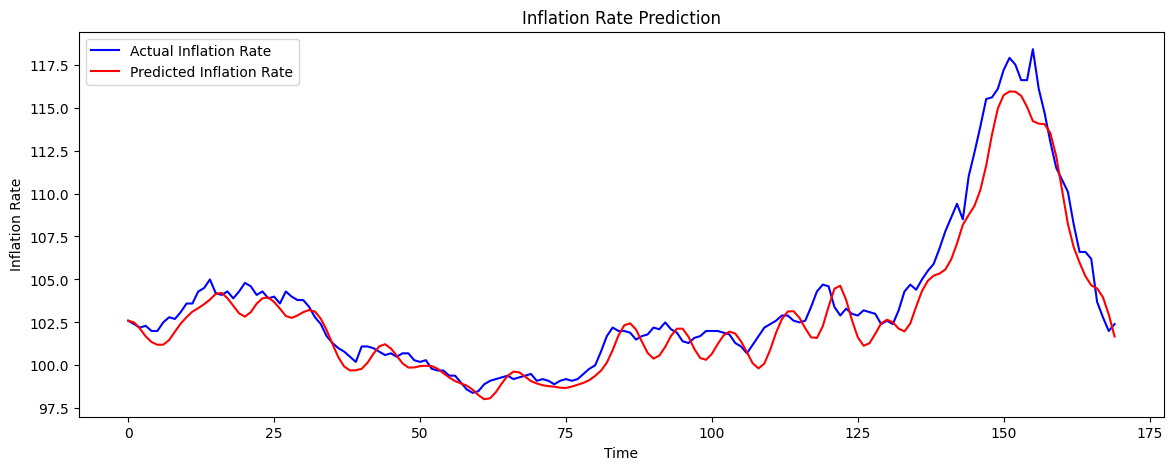

In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data = pd.read_csv('gus_1987_2024.csv')

features = data.iloc[:, 2:3].values

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)


def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 24
X, y = create_sequences(features_scaled, seq_length)

split = int(len(X) * 0.6)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

model = Sequential()

model.add(Input((seq_length, X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(50))
model.add(Dropout(0.3))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=3, epochs=12, validation_split=0.1)

loss = model.evaluate(X_test, y_test)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions = predictions - (predictions[0] - y_test_inv[0])

plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, color='blue', label='Actual Inflation Rate')
plt.plot(predictions, color='red', label='Predicted Inflation Rate')
plt.title('Inflation Rate Prediction')
plt.xlabel('Time')
plt.ylabel('Inflation Rate')
plt.legend()
plt.show()